<a href="https://colab.research.google.com/github/abhinavdayal/EVA4/blob/master/S14/Final_Data_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Generation

In [0]:
# find a random location to put the cow image
from random import seed
import random
# seed random number generator

## Helper methods

### random crop and flip


In [0]:
import math
import os
from tqdm.notebook import tqdm

# flip image horizontally with a probability of 0.5
def randomflip(im):
  r = random.random()
  if r>0.5:
    return im.transpose(Image.FLIP_LEFT_RIGHT), True
  return im, False

# crops image and its segment to given size and possibly flips is horizontally
def random_crop_n_flip(img, newsize=(250, 250)):
  img, f = randomflip(img)
  w, h = img.size

  if h>w:
    w, h = (newsize[0], int(newsize[0]*h/w))
    img = img.resize((w,h))
    left, right = 0, w
    bottom, top = h, h-w
  else:
    w, h = (int(newsize[1]*w/h), newsize[1])
    img = img.resize((w,h))
    left = int(random.random()*(w-h))
    right = left+h
    bottom, top = h, 0

  cropped = img.crop((left, top, right, bottom))  # size: 45, 45
  
  return cropped

### Location selection to place foreground object
We want to place foreground object on ground plane randomly. Below functions will first extract the potential ground pixels and then pick one at random as center of the foreground object

In [0]:
def show_binary_image(img):
  display(Image.fromarray((img*255).astype(np.uint8), mode='L'))

def pick_random_center(w,h):
  py = int(random.random()*h)
  px = int(random.random()*w)
  return px, py

### Scale selection
Next we want to determine how big the foreground should be. We are picing a random alue between 0.3 and 0.6. A scale indicates what proportion of area of background image should the foreground image span.

In [0]:
def scaled_foreground(fg, newsize, py):
  fh, fw = fg.height, fg.width
  # get area wrt bg size
  r = min(random.random()+0.3, 0.6)
  csize = (newsize[0]*r, newsize[1]*r)
  ar = csize[0]*csize[1]

  # resize based on area and aspect
  dw = int(math.sqrt(ar)*fw/fh)
  dh = int(dw*(fh/fw))
  fg = fg.resize((dw, dh))

  # get mask of resized
  mask = np.array(fg)[:, :, 3]
  mask[mask<200]=0
  mask = Image.fromarray(mask, mode='L')

  return fg, mask

def place(bg, fg, mask, px, py):
  fh, fw = fg.height, fg.width
  py -= fh//2
  px -= fw//2
  bg.paste(fg, (px, py), mask)
  fmask = Image.new('1', bg.size)
  fmask.paste(mask, (px, py))

  return bg, fmask.resize((224, 224))

## Generation of flipped foreground images
Caution : Run only once

In [0]:
def flipforeground(fgpath, imgno):
  fglist = list(filter(lambda x: x.endswith('png'), os.listdir(fgpath)))
  print('Creating flipped foregrounds')
  for i in range(len(fglist)):
    fgimg = os.path.join(fgpath, fglist[i])
    fgim = Image.open(fgimg)
    fgout = fgim.transpose(Image.FLIP_LEFT_RIGHT)
    fgout.save(os.path.join(fgpath, f"image{imgno:0>3}.png"))
    imgno +=1

#We have 100 foreground images. the flipped images numbers will start from 101
flipforeground('/content/drive/My Drive/EVA4/data/foreground', imgno=101)

## Creation of masks for the 200 foreground images (100 original + 100 flipped)

In [0]:
cd '/content/drive/My Drive/EVA4/data/foreground'

/content/drive/My Drive/EVA4/data/foreground


In [0]:
#foreground image names are in the pattern image001.png... want to save this as mask001.jpg
from PIL import Image
import numpy as np
import osqp
fgpath = os.path.join('/content/drive/My Drive/EVA4/data', 'foreground')

for f in os.listdir():
  rgba = np.array(Image.open(f).convert('RGBA'))
  rgba[rgba[..., -1]>0] = [255,255,255,255]
  rgba[rgba[..., -1]==0] = [0, 0,0, 255]
  im = (Image.fromarray(rgba)).convert('RGB')
  im.save('/content/drive/My Drive/EVA4/data/masks/mask'+f[5:-4]+'.jpg')

### Main Methods
These methods take in the input folders and produce the outputs.

# Pipeline
1. We need to select BG image
2. We need to select a FG image
3. 448x448 image -> Depth -> 224x224.
4. 4000 as a batch size, and we create 200, 448x448 images so a 200x448x448x3 size tensor
5. we pass this to depth network and it return 200x224x224x1
6. in a loop we resize our 200 448x448 images to 224x224 and save then in a zip folder
7. at the same time we save the mask 224x224 and the depth.
we will have 2000 batches, 400000 images.
8 while we save the depth images we also want to save .npy numpy array for that respective image because that is what will be our training data.

if 1 batch takes 10 sec 20000 sec = 6 hours


In [0]:
#path for background and foreground images
bgpath = os.path.join('/content/drive/My Drive/EVA4/data', "bgimages")
fgpath = os.path.join('/content/drive/My Drive/EVA4/data', "foreground")
#list of filenames of background images and foreground
bgimagelist = list(filter(lambda x: x.endswith('jpg'), os.listdir(bgpath)))
fgimagelist = list(filter(lambda x: x.endswith('png'), os.listdir(fgpath)))

## Depth estimation
source : https://github.com/ialhashim/DenseDepth

In [0]:
%tensorflow_version 1.x

In [0]:
import os
import glob
import matplotlib
from keras.engine.topology import Layer, InputSpec
import keras.utils.conv_utils as conv_utils
import tensorflow as tf
import keras.backend as K

Using TensorFlow backend.


In [0]:
class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

    def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        
        return tf.image.resize_images(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR, align_corners=True)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
import numpy as np
from PIL import Image

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=1, maxDepth=100, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def to_multichannel(i):
    if i.shape[2] == 3: 
      return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)
        


In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./nyu.h5

--2020-05-09 02:05:51--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.28.27
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.28.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./nyu.h5’

./nyu.h5            100%[===================>] 164.89M  11.6MB/s    in 16s     

2020-05-09 02:06:08 (10.3 MB/s) - ‘./nyu.h5’ saved [172897376/172897376]



In [0]:

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from matplotlib import pyplot as plt

In [0]:
# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

In [0]:
print('Loading model...')
model='/content/nyu.h5'
# Load model into GPU / CPU
model = load_model(model, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(model))


Loading model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Model loaded (<keras.engine.training.Model object at 0x7f7379c95b70>).


## depth image creation
Create depth images from output of above depth network on a single batch.

In [0]:
from PIL import Image
import numpy as np


def create_images(outputs, info, zipfolder):   
    for i in range(outputs.shape[0]):
      #print(info[i])
      a = outputs[i].reshape((224, 224)).astype(np.float32)
      b = 1 - a
      m = np.max(b)
      mn = np.min(b)
      b = (b-mn)/(m-mn)
      b = (b*255).astype(np.uint8)
      img = Image.fromarray(b, mode='L')
      img = img.resize((info[i][1], info[i][2]))
      n = info[i][0]
      #a = np.array(img).astype(np.uint8)
      #np.save(os.path.join(outpath, f"depth{n[0]}.npy"), a)
      #np.save("npytemp.npy", a)
      img.save("depthtemp.jpg")
      #img.save(os.path.join(outpath, f"depth{n[0]}.jpg"))
      zipfolder.write('depthtemp.jpg', f'output/depth/fgbg{n:0>6d}.jpg')
      #zipfolder.write('npytemp.npy', f'output/depth/fgbg{n:0>6d}.npy')



In [0]:
# pipeline
# for a batch size of 2000 
# len(bg) = 1
# len(fg) = 100
# multiplier = 20
# this method saves fgonbg, mask, depth images on to their respective folders of the zipfolder (batch - 2000)
# This method need to be called twice for every bg...(ater testing for several batch sizes)
# original background images are 448X448, we are resizing fgonbg and mask to 224X224
# passing 448$448 to depth prediction and getting 224X224.
# All 1200 K images are of size 224 X 224

def run_one_batch(inpath, bg, fglist, zipfolder, multiplier=20, imgno=0):
  loaded_images =[]
  imagemeta = []

  bgpath = os.path.join(inpath, "bgimages")
  fgpath = os.path.join(inpath, "foreground")

  bgimg = os.path.join(bgpath, bg)
  original_im = Image.open(bgimg)
  w, h = original_im.width, original_im.height

  for i in tqdm(range(len(fglist))):
    fgimg = os.path.join(fgpath, fglist[i])
    fg = Image.open(fgimg)

    for _ in range(multiplier):
      cropped = random_crop_n_flip(original_im, (448,448))
      px, py = pick_random_center(448, 448)
      fg, mask = scaled_foreground(fg, (448,448), py)
      finalimg, finalmask = place(cropped, fg, mask, px, py)
      imagemeta.append((imgno, finalimg.width, finalimg.height))
      x = np.clip(np.asarray(finalimg, dtype=float) / 255, 0, 1)

      finalimg.resize((224, 224)).save("bgtemp.jpg", optimize = True, quality=60)
      finalmask.resize((224, 224)).save("maskimg.jpg", optimize = True, quality=60)
      
      loaded_images.append(x)
      
      zipfolder.write('bgtemp.jpg', f'output/images/fgbg{imgno:0>6d}.jpg')
      zipfolder.write('maskimg.jpg', f'output/masks/mask{imgno:0>6d}.jpg')
      imgno += 1
  print("Generating Depth images .....")
  depthbatch = np.stack(loaded_images, axis=0)
  outputs = predict(model, depthbatch)
  create_images(outputs, imagemeta, zipfolder)
  
  return imgno


    
   # multiplex
   # create a numpy array
   # stack all 448x448 bg-fg images in that array, along size create 224x224 masks
   # pass that to depth network to get 224x224 depth numpy values
   # now resize 448x448 to 224x224 images and save in zipfolder/images
   # save masks in the masks zipfolder/folder
   # save depth images as well as .npy values in depths zipfolder/folder

# time for one batch, and see it should be ~5 sec but < 10sec

## Data Generation
1. created a zipfile with the name fgbganddepth2.zip and opened it in append mode
2. generated and saved fgbg, mask and dpeth for first 25 background images (total of 100 K of each type). File numbers are also started from 000001 to 100000
3. saved the intermediated zip to drive
4. Repeated the steps 2 and 3 for the rest 75 background images. which generated a total of 400 K images of each type.

In [0]:
from zipfile import ZipFile
out = ZipFile('fgbganddepth2.zip', mode='a')

In [0]:
#overlaying fg on bg and generating masks for 25 background images
imgno = 0
for x in range(25):
  print("background image - ", (x+1))
  imgno = run_one_batch('/content/drive/My Drive/EVA4/data', bgimagelist[x], fgimagelist[:100], zipfolder=out, multiplier=20, imgno=imgno)
  imgno = run_one_batch('/content/drive/My Drive/EVA4/data', bgimagelist[x], fgimagelist[100:], zipfolder=out, multiplier=20, imgno=imgno)

print("images created so far: ", imgno)

background image -  1



Generating Depth images .....




Generating Depth images .....
background image -  2



Generating Depth images .....



Generating Depth images .....
background image -  3



Generating Depth images .....



Generating Depth images .....
background image -  4



Generating Depth images .....



Generating Depth images .....
background image -  5



Generating Depth images .....



Generating Depth images .....
background image -  6



Generating Depth images .....



Generating Depth images .....
background image -  7



Generating Depth images .....



Generating Depth images .....
background image -  8



Generating Depth images .....



Generating Depth images .....
background image -  9



Generating Depth images .....



Generating Depth images .....
background image -  10



Generating Depth images .....



Generating Depth images .....
background image -  11



Generating Depth images .....



Generating Depth images .....
background image -  12



Generating Depth images .....



Generating Depth images .....
background image -  13



Generating Depth images .....



Generating Depth images .....
background image -  14



Generating Depth images .....



Generating Depth images .....
background image -  15



Generating Depth images .....



Generating Depth images .....
background image -  16



Generating Depth images .....



Generating Depth images .....
background image -  17



Generating Depth images .....



Generating Depth images .....
background image -  18



Generating Depth images .....



Generating Depth images .....
background image -  19



Generating Depth images .....



Generating Depth images .....
background image -  20



Generating Depth images .....



Generating Depth images .....
background image -  21



Generating Depth images .....



Generating Depth images .....
background image -  22



Generating Depth images .....



Generating Depth images .....
background image -  23



Generating Depth images .....



Generating Depth images .....
background image -  24



Generating Depth images .....



Generating Depth images .....
background image -  25



Generating Depth images .....



Generating Depth images .....
images created so far:  100000


In [0]:
out.close()

In [0]:
cp fgbganddepth2.zip /content/drive/'My Drive'/EVA4/data

In [0]:
cp fgbganddepth2.zip /content/drive/'My Drive'/EVA4/custom_data/

### second set

In [0]:
from zipfile import ZipFile
out = ZipFile('fgbganddepth2.zip', mode='a')

In [0]:
#overlaying fg on bg and generating masks for 25 background images

for x in range(25,50):
  print("background image - ", (x+1))
  imgno = run_one_batch('/content/drive/My Drive/EVA4/data', bgimagelist[x], fgimagelist[:100], zipfolder=out, multiplier=20, imgno=imgno)
  imgno = run_one_batch('/content/drive/My Drive/EVA4/data', bgimagelist[x], fgimagelist[100:], zipfolder=out, multiplier=20, imgno=imgno)

print("images created so far: ", imgno)

background image -  26



Generating Depth images .....



Generating Depth images .....
background image -  27



Generating Depth images .....



Generating Depth images .....
background image -  28



Generating Depth images .....



Generating Depth images .....
background image -  29



Generating Depth images .....



Generating Depth images .....
background image -  30



Generating Depth images .....



Generating Depth images .....
background image -  31



Generating Depth images .....



Generating Depth images .....
background image -  32



Generating Depth images .....



Generating Depth images .....
background image -  33



Generating Depth images .....



Generating Depth images .....
background image -  34



Generating Depth images .....



Generating Depth images .....
background image -  35



Generating Depth images .....



Generating Depth images .....
background image -  36



Generating Depth images .....



Generating Depth images .....
background image -  37



Generating Depth images .....



Generating Depth images .....
background image -  38



Generating Depth images .....



Generating Depth images .....
background image -  39



Generating Depth images .....



Generating Depth images .....
background image -  40



Generating Depth images .....



Generating Depth images .....
background image -  41



Generating Depth images .....



Generating Depth images .....
background image -  42



Generating Depth images .....



Generating Depth images .....
background image -  43



Generating Depth images .....



Generating Depth images .....
background image -  44



Generating Depth images .....



Generating Depth images .....
background image -  45



Generating Depth images .....



Generating Depth images .....
background image -  46



Generating Depth images .....



Generating Depth images .....
background image -  47



Generating Depth images .....



Generating Depth images .....
background image -  48



Generating Depth images .....



Generating Depth images .....
background image -  49



Generating Depth images .....



Generating Depth images .....
background image -  50



Generating Depth images .....



Generating Depth images .....
images created so far:  200000


In [0]:
out.close()

In [0]:
cp fgbganddepth2.zip /content/drive/'My Drive'/EVA4/data

In [0]:
cp fgbganddepth2.zip /content/drive/'My Drive'/EVA4/custom_data/

## Third set

In [0]:
out = ZipFile('fgbganddepth2.zip', mode='a')

In [0]:
#overlaying fg on bg and generating masks for 25 background images

for x in range(50,75):
  print("background image - ", (x+1))
  imgno = run_one_batch('/content/drive/My Drive/EVA4/data', bgimagelist[x], fgimagelist[:100], zipfolder=out, multiplier=20, imgno=imgno)
  imgno = run_one_batch('/content/drive/My Drive/EVA4/data', bgimagelist[x], fgimagelist[100:], zipfolder=out, multiplier=20, imgno=imgno)

print("images created so far: ", imgno)

background image -  51



Generating Depth images .....



Generating Depth images .....
background image -  52



Generating Depth images .....



Generating Depth images .....
background image -  53



Generating Depth images .....



Generating Depth images .....
background image -  54



Generating Depth images .....



Generating Depth images .....
background image -  55



Generating Depth images .....



Generating Depth images .....
background image -  56



Generating Depth images .....



Generating Depth images .....
background image -  57



Generating Depth images .....



Generating Depth images .....
background image -  58



Generating Depth images .....



Generating Depth images .....
background image -  59



Generating Depth images .....



Generating Depth images .....
background image -  60



Generating Depth images .....



Generating Depth images .....
background image -  61



Generating Depth images .....



Generating Depth images .....
background image -  62



Generating Depth images .....



Generating Depth images .....
background image -  63



Generating Depth images .....



Generating Depth images .....
background image -  64



Generating Depth images .....



Generating Depth images .....
background image -  65



Generating Depth images .....



Generating Depth images .....
background image -  66



Generating Depth images .....



Generating Depth images .....
background image -  67



Generating Depth images .....



Generating Depth images .....
background image -  68



Generating Depth images .....



Generating Depth images .....
background image -  69



Generating Depth images .....



Generating Depth images .....
background image -  70



Generating Depth images .....



Generating Depth images .....
background image -  71



Generating Depth images .....



Generating Depth images .....
background image -  72



Generating Depth images .....



Generating Depth images .....
background image -  73



Generating Depth images .....



Generating Depth images .....
background image -  74



Generating Depth images .....



Generating Depth images .....
background image -  75



Generating Depth images .....



Generating Depth images .....
images created so far:  300000


In [0]:
out.close()

In [0]:
cp fgbganddepth2.zip /content/drive/'My Drive'/EVA4/data

In [0]:
cp fgbganddepth2.zip /content/drive/'My Drive'/EVA4/custom_data/

## Fourth set

In [0]:
out = ZipFile('fgbganddepth2.zip', mode='a')

In [0]:
#overlaying fg on bg and generating masks for 25 background images

for x in range(75,100):
  print("background image - ", (x+1))
  imgno = run_one_batch('/content/drive/My Drive/EVA4/data', bgimagelist[x], fgimagelist[:100], zipfolder=out, multiplier=20, imgno=imgno)
  imgno = run_one_batch('/content/drive/My Drive/EVA4/data', bgimagelist[x], fgimagelist[100:], zipfolder=out, multiplier=20, imgno=imgno)

print("images created so far: ", imgno)

background image -  76



Generating Depth images .....



Generating Depth images .....
background image -  77



Generating Depth images .....



Generating Depth images .....
background image -  78



Generating Depth images .....



Generating Depth images .....
background image -  79



Generating Depth images .....



Generating Depth images .....
background image -  80



Generating Depth images .....



Generating Depth images .....
background image -  81



Generating Depth images .....



Generating Depth images .....
background image -  82



Generating Depth images .....



Generating Depth images .....
background image -  83



Generating Depth images .....



Generating Depth images .....
background image -  84



Generating Depth images .....



Generating Depth images .....
background image -  85



Generating Depth images .....



Generating Depth images .....
background image -  86



Generating Depth images .....



Generating Depth images .....
background image -  87



Generating Depth images .....



Generating Depth images .....
background image -  88



Generating Depth images .....



Generating Depth images .....
background image -  89



Generating Depth images .....



Generating Depth images .....
background image -  90



Generating Depth images .....



Generating Depth images .....
background image -  91



Generating Depth images .....



Generating Depth images .....
background image -  92



Generating Depth images .....



Generating Depth images .....
background image -  93



Generating Depth images .....



Generating Depth images .....
background image -  94



Generating Depth images .....



Generating Depth images .....
background image -  95



Generating Depth images .....



Generating Depth images .....
background image -  96



Generating Depth images .....



Generating Depth images .....
background image -  97



Generating Depth images .....



Generating Depth images .....
background image -  98



Generating Depth images .....



Generating Depth images .....
background image -  99



Generating Depth images .....



Generating Depth images .....
background image -  100



Generating Depth images .....



Generating Depth images .....
images created so far:  400000


In [0]:
out.close()

In [0]:
cp fgbganddepth2.zip /content/drive/'My Drive'/EVA4/data

In [0]:
cp fgbganddepth2.zip /content/drive/'My Drive'/EVA4/custom_data/

## Thank God, Google and my Team

## Data Statistics (PUT THESE IN README)
* Data visualization
* total no.of  images
* Mean
* Standard Deviation

In [0]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/EVA4/data/fgbganddepth2.zip', mode='r') as input:
  input.extractall('.')


### Calcalates mean and standard deviation

In [0]:
from tqdm import tqdm_notebook
import numpy as np
import cv2

def findMeanStd(inpath):
  n=0
  s = np.zeros(3)
  sq = np.zeros(3)

  imagelist = list(filter(lambda x: x.endswith('jpg'), os.listdir(inpath)))

  for data in tqdm_notebook(imagelist):
    bgimg = os.path.join(inpath, data)
    image = cv2.imread(bgimg)
    x = np.array(image)/255
    s += x.sum(axis = (0, 1))
    sq += np.sum(np.square(x), axis = (0,1))
    n += x.shape[0]*x.shape[1]

  mu = s/n
  std = np.sqrt((sq/n - np.square(mu)))
  return (len(imagelist), mu, std)




### Displays images as a horizontal grid

In [0]:
def displaygrid(inpath, imlist, imtype='jpg'):
  images = [Image.open(os.path.join(inpath, x)) for x in imlist]
  widths, heights = zip(*(i.size for i in images))
  
  total_width = sum(widths)
  max_height = max(heights)

  if (imtype=='jpg'):
    new_im = Image.new('RGB', (total_width, max_height))
  else:
    new_im = Image.new('RGBA', (total_width, max_height))

  offset = 0
  for im in images:
    new_im.paste(im, (offset, 0))
    offset += im.size[0]
    
  return new_im

### Background images

In [0]:
print("Statistics of image data")
total, mean, std = findMeanStd('/content/drive/My Drive/EVA4/data/bgimages')
print("Total No.of images : ", total)
print("Mean : ", mean)
print("Standard Deviaiton : ", std)

Statistics of image data



Total No.of images :  100
Mean :  [0.52615038 0.53840251 0.50975785]
Standard Deviaiton :  [0.2873205  0.24685429 0.24804363]


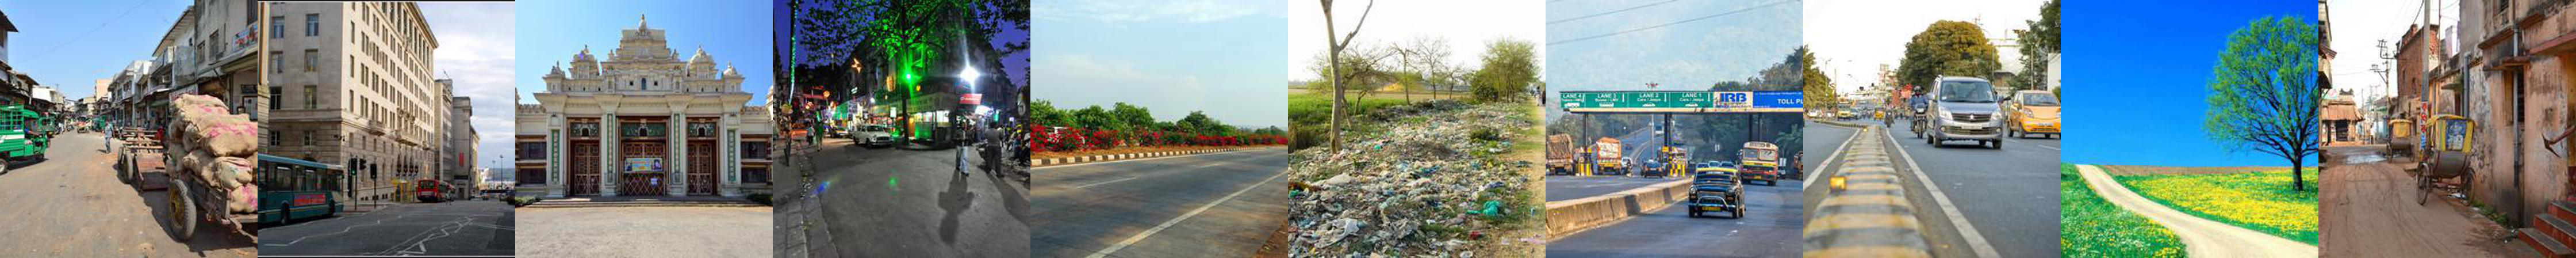

In [0]:
imglist = list(filter(lambda x: x.endswith('jpg'), os.listdir('/content/drive/My Drive/EVA4/data/bgimages')))
imglist.sort()
im = displaygrid('/content/drive/My Drive/EVA4/data/bgimages', imglist[30:40])
im.save('bgimages.jpg')
display(im)

### Foreground images

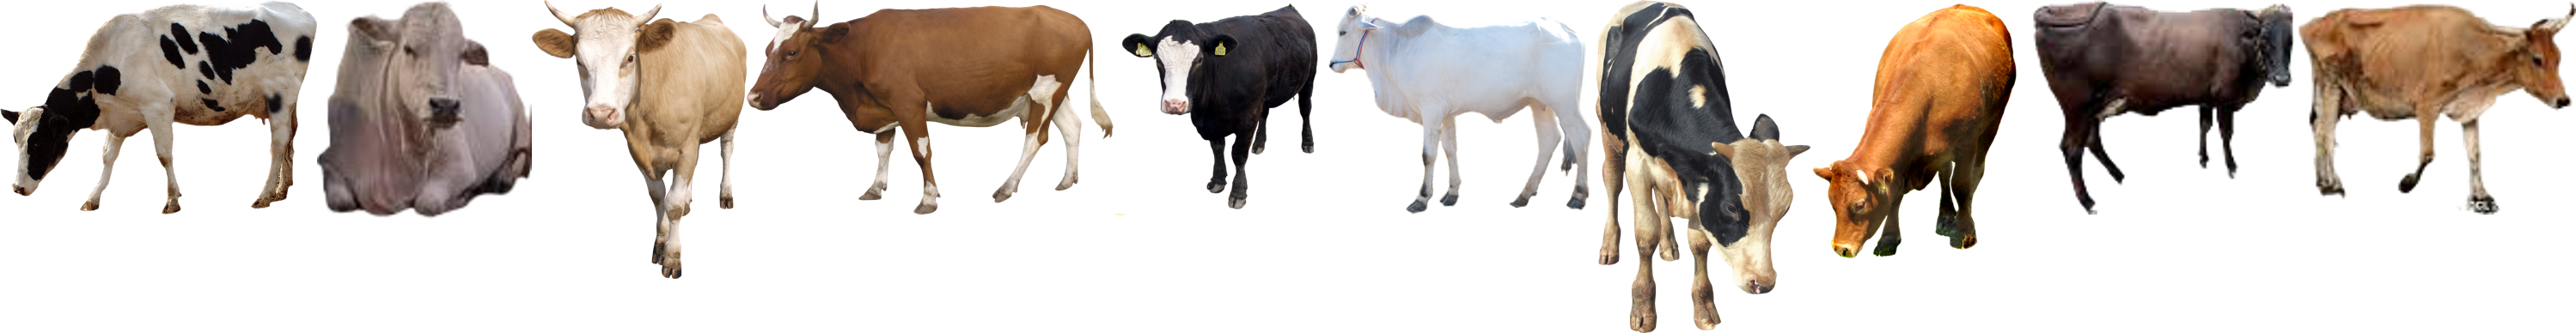

In [0]:
imglist = list(filter(lambda x: x.endswith('png'), os.listdir('/content/drive/My Drive/EVA4/data/foreground')))
imglist.sort()
im = displaygrid('/content/drive/My Drive/EVA4/data/foreground', imglist[10:20], imtype='png')
im.save('foreground.png')
display(im)

### Masks

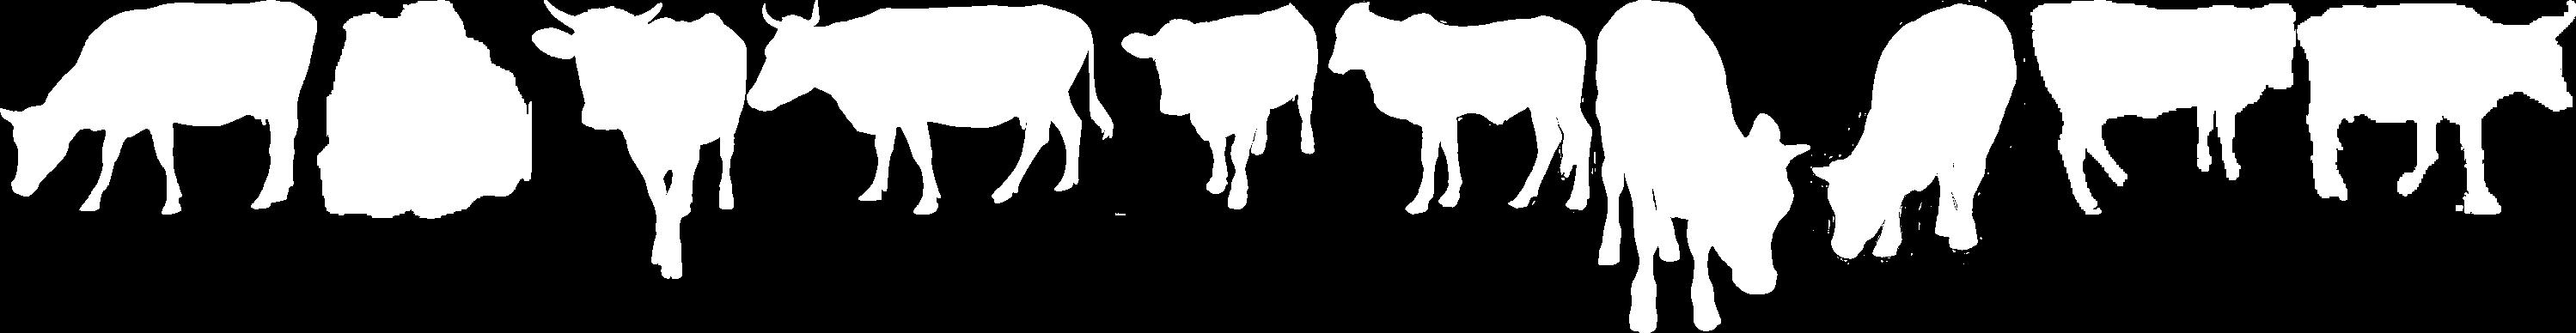

In [0]:
imglist = list(filter(lambda x: x.endswith('jpg'), os.listdir('/content/drive/My Drive/EVA4/data/masks')))
imglist.sort()
im = displaygrid('/content/drive/My Drive/EVA4/data/masks', imglist[10:20])
im.save('masks.jpg')
display(im)

### Background images after overlaying foreground

In [0]:
print("Statistics of image data")
total, mean, std = findMeanStd('output/images')
print("Total No.of images : ", total)
print("Mean : ", mean)
print("Standard Deviaiton : ", std)

Statistics of image data



Total No.of images :  400000
Mean :  [0.50610699 0.5250236  0.51219183]
Standard Deviaiton :  [0.28525343 0.24801724 0.24747186]


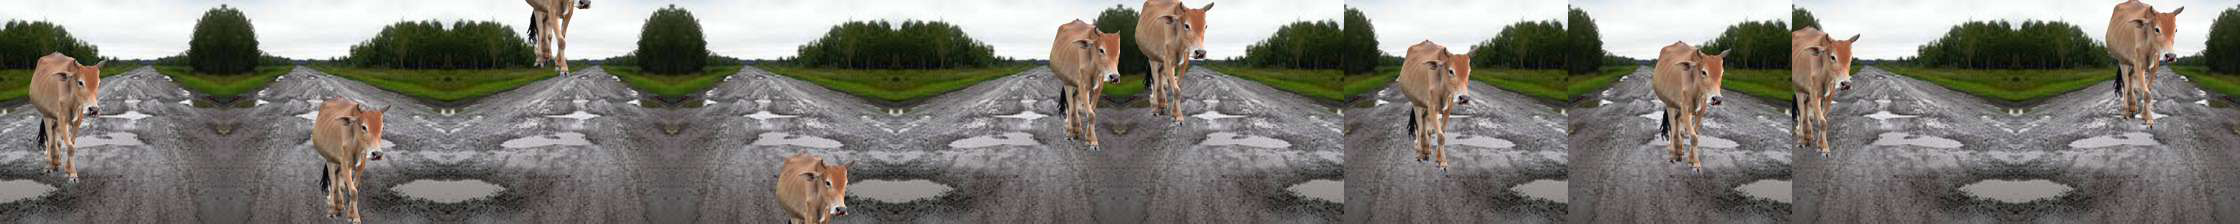

In [0]:
imglist = list(filter(lambda x: x.endswith('jpg'), os.listdir('output/images')))
imglist.sort()
im = displaygrid('output/images', imglist[:10])
im.save('fgbggrid.jpg')
display(im)

### Respective masks of overlayed data

In [0]:
print("Statistics of Mask data")
total, mean, std = findMeanStd('output/masks')
print("Total No.of images : ", total)
print("Mean : ", mean)
print("Standard Deviaiton : ", std)

Statistics of Mask data



Total No.of images :  400000
Mean :  [0.13532567 0.13532567 0.13532567]
Standard Deviaiton :  [0.33999708 0.33999708 0.33999708]


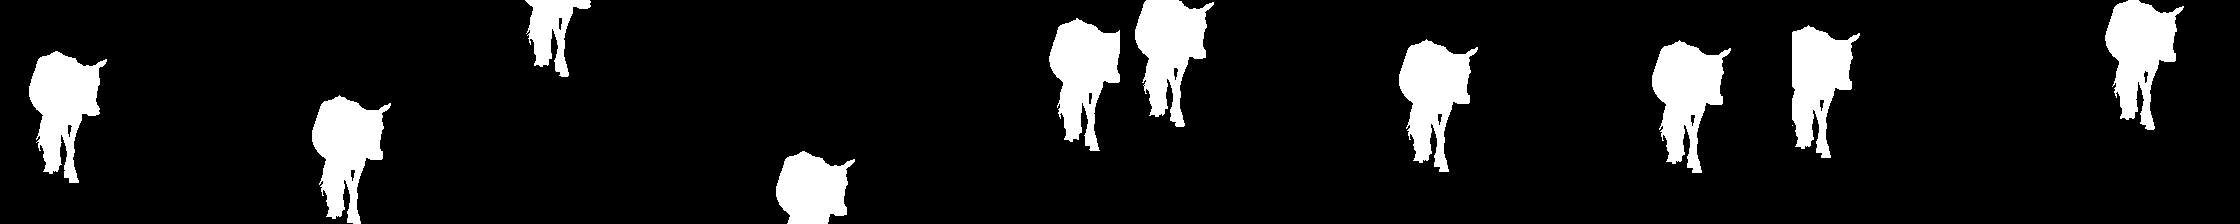

In [0]:
imglist = list(filter(lambda x: x.endswith('jpg'), os.listdir('output/masks')))
imglist.sort()
im = displaygrid('output/masks', imglist[:10])
im.save('maskoverlay.jpg')
display(im)

### Depths

In [0]:
print("Statistics of Mask data")
total, mean, std = findMeanStd('output/depth')
print("Total No.of images : ", total)
print("Mean : ", mean)
print("Standard Deviaiton : ", std)

Statistics of Mask data



Total No.of images :  400000
Mean :  [0.57016144 0.57016144 0.57016144]
Standard Deviaiton :  [0.25914387 0.25914387 0.25914387]


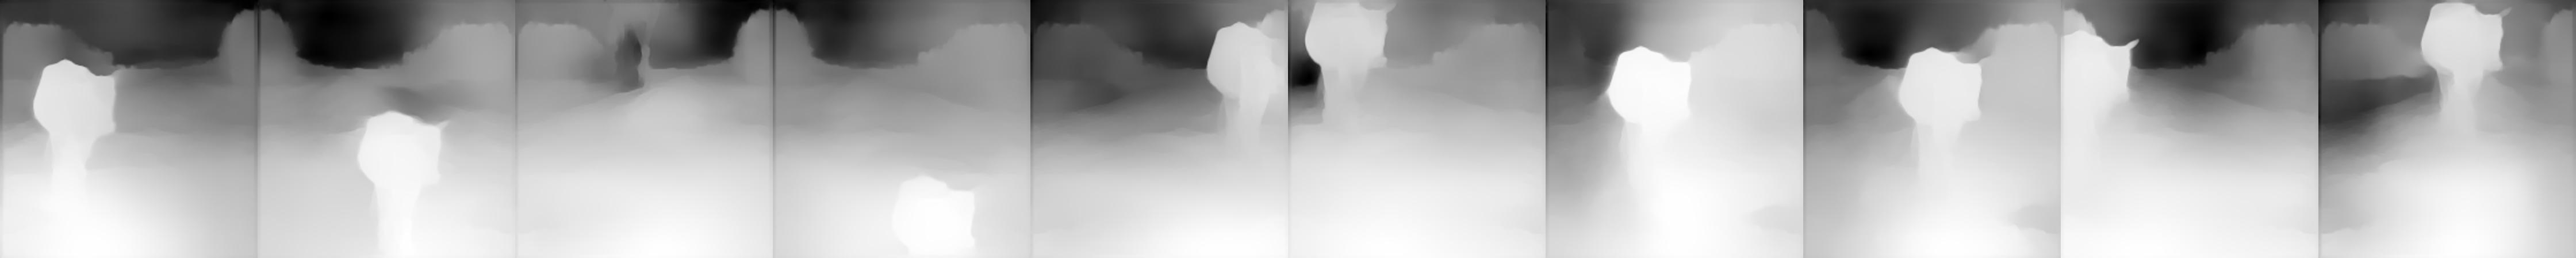

In [0]:
imglist = list(filter(lambda x: x.endswith('jpg'), os.listdir('output/depth')))
imglist.sort()
im = displaygrid('output/depth', imglist[:10])
im.save('depth.jpg')
display(im)